# THE 8-PUZZLE

## STANDARD FORMULATION

Including path to previous directory in built-in variable `sys.path`:

In [1]:
import sys

sys.path.append('../')

Importing the relevant libraries and the standard formulation of the 8-puzzle problem (the submodule `.formulations` returns the default):

- Initial state
- Objective state
- Actions
- Transition model

In [2]:
from time import time
from collections import deque
from puzzle import formulations

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Defining the manhattan heuristic (this is the information that will be embedded in the search):

In [3]:
N = 3
OBJ_GRID = formulations.objective_grid(N)

def heuristic_manhattan(grid):
    distance = 0

    for x in range(1, 9):
        x0, y0 = np.where(grid == x)
        x0, y0 = x0[0], y0[0]
        
        x1, y1 = np.where(OBJ_GRID == x)
        x1, y1 = x1[0], y1[0]
        
        distance += abs(x1 - x0) + abs(y1 - y0)

    return distance

Defining the classes of the search problem (the `result` attribute defines the transition model) and a search node:

In [4]:
class Problem:
    def __init__(self, initial, objective, actions, result):
        self.initial = initial
        self.objective = objective
        self.actions = actions
        self.result = result

class Node:
    def __init__(self, state, cost, parent, action):
        self.state  = state
        self.cost   = cost
        self.parent = parent
        self.action = action
        self.f      = self.cost + heuristic_manhattan(self.state)

    def __str__(self):
        return '\n\n'.join(['  '.join(map(str, grid)) for grid in self.state[0:2]]) + \
               '  >>>  ' + str(self.cost) + '\n\n' + \
               '\n\n'.join(['  '.join(map(str, grid)) for grid in self.state[2:]])

    @classmethod
    def child(cls, problem, parent, action):
        state = problem.result(parent.state, action)

        return cls(state, parent.cost + 1, parent, action)

    @property
    def solution(self):
        solution = []

        node = self
        while node:
            solution.append(node)
            node = node.parent

        solution.reverse()

        return solution

Creating new instances of the problem with different resolution complexities:

In [5]:
grid1 = np.array([[3, 2, 7],
                  [4, 8, 1],
                  [6, 5, 0]])

grid2 = np.array([[3, 2, 7],
                  [4, 8, 0],
                  [6, 5, 1]])

grid3 = np.array([[3, 2, 0],
                  [4, 8, 7],
                  [6, 5, 1]])

grid4 = np.array([[2, 6, 1],
                  [7, 5, 0],
                  [8, 3, 4]])

grid5 = np.array([[7, 2, 4],
                  [5, 0, 6],
                  [8, 3, 1]])

puzzle_12_steps = Problem(Node(grid1, 0, None, None), formulations.won_comp,
                          formulations.available_moves, formulations.move_grid)

puzzle_13_steps = Problem(Node(grid2, 0, None, None), formulations.won_comp,
                          formulations.available_moves, formulations.move_grid)

puzzle_14_steps = Problem(Node(grid3, 0, None, None), formulations.won_comp,
                          formulations.available_moves, formulations.move_grid)

puzzle_23_steps = Problem(Node(grid4, 0, None, None), formulations.won_comp,
                          formulations.available_moves, formulations.move_grid)

puzzle_26_steps = Problem(Node(grid5, 0, None, None), formulations.won_comp,
                          formulations.available_moves, formulations.move_grid)

print(puzzle_12_steps.initial)
print('=' * 7)
print(puzzle_13_steps.initial)
print('=' * 7)
print(puzzle_14_steps.initial)
print('=' * 7)
print(puzzle_23_steps.initial)
print('=' * 7)
print(puzzle_26_steps.initial)

3  2  7

4  8  1  >>>  0

6  5  0
3  2  7

4  8  0  >>>  0

6  5  1
3  2  0

4  8  7  >>>  0

6  5  1
2  6  1

7  5  0  >>>  0

8  3  4
7  2  4

5  0  6  >>>  0

8  3  1


## PRIORITY QUEUE

Implements a priority queue via a min-heap tree:

- In this binary tree the smallest element is always at the root
- Elements must be objects that are compared by the `f` property

In [6]:
class MinHeap:
    def __init__(self):
        self.contents = []
        self.capacity = 0
        self.size = 0
        
    def __getitem__(self, index):
        return self.contents[index]

    def remove_min(self):
        if (self.size < 1):
            return None

        minimum = self.contents[0]
        self.contents[0] = self.contents[self.size-1]
        self.size -= 1

        self.min_heapify(0)

        return minimum
    
    def remove(self, index):
        self.contents.pop(index)
        
        self.capacity -= 1
        self.size -= 1

    def add(self, node):
        self.insert_node(self.size, node)
        self.size += 1

    def parent(self, i):
        return int((i - 1) / 2)

    def child_left(self, i):
        return i*2 + 1

    def child_right(self, i):
        return i*2 + 2
    
    def index(self, state):
        for position, grid in enumerate([n.state for n in self.contents]):
            if np.array_equal(state, grid):
                return position
        
        return None

    def swap_nodes(self, i, j):
        temp = self.contents[i]
        self.contents[i] = self.contents[j]
        self.contents[j] = temp

    def min_heapify(self, i):
        l = self.child_left(i)
        r = self.child_right(i)

        minimum = i

        if l < self.size and self.contents[i].f > self.contents[l].f:
            minimum = l

        if r < self.size and self.contents[minimum].f > self.contents[r].f:
            minimum = r

        if minimum != i:
            self.swap_nodes(i, minimum)
            self.min_heapify(minimum)

    def insert_node(self, i, node):
        if self.capacity == self.size:
            self.contents.append(node)
            self.capacity += 1
        else:
            self.contents[i] = node
        
        while i > 0 and self.contents[self.parent(i)].f > self.contents[i].f:
            self.swap_nodes(i, self.parent(i))
            i = self.parent(i)

    def list_nodes(self):
        return self.contents[:self.size]

In [7]:
class PriorityQueue:
    def __init__(self):
        self.heap = MinHeap()
        
    def __getitem__(self, idx):
        return self.heap[idx]

    def index(self, node):
        return self.heap.index(node.state)

    def add(self, node):
        self.heap.add(node)
        
    def remove(self, node):
        self.heap.remove(self.index(node))

    def remove_idx(self, idx):
        self.heap.remove(idx)

    def remove_min(self):
        return self.heap.remove_min()

    @property
    def list_nodes(self):
        return self.heap.list_nodes()

## A*

### GRAPH-SEARCH

Constants for current search status:

In [8]:
SEARCH_NOT_STARTED = 0
SEARCH_STARTED = 1
SEARCH_FAIL = 2
SEARCH_SUCCESS = 3

Class that will implement A* graph search:

In [9]:
class ASGS:
    def __init__(self, problem):
        self.problem   = problem
        self.explored  = deque([])
        self.frontier  = PriorityQueue()
        self.situation = SEARCH_NOT_STARTED
        self.solution  = None

    def step_search(self):
        # Checking three initial conditions:
        # Root node initial check
        # Checking if the search process failed
        # Checking if the search was successful
        if self.situation == SEARCH_NOT_STARTED:
            self.frontier.add(self.problem.initial)
            self.situation = SEARCH_STARTED
        elif self.situation == SEARCH_FAIL:
            print('Search process failed!')
            return
        elif self.situation == SEARCH_SUCCESS:
            print('Solution already found!')
            return

        # Performing the search step
        node = self.frontier.remove_min()

        # Empty border ends the search
        if not node:
            self.situation = SEARCH_FAIL
            return
        
        if self.problem.objective(node.state, OBJ_GRID):
            self.solution = node.solution
            self.situation = SEARCH_SUCCESS
            return

        self.explored.append(node.state)

        for action in self.problem.actions(node.state):
            child = Node.child(self.problem, node, action)
            idx_frontier = self.frontier.index(child)

            if idx_frontier:
                if child.f < self.frontier[idx_frontier].f:
                    self.frontier.remove_idx(idx_frontier)
                    self.frontier.add(child)
            elif not self.explored_node(child.state):                
                self.frontier.add(child)

    def search(self):
        # Loop that performs the search
        while self.situation == SEARCH_STARTED or self.situation == SEARCH_NOT_STARTED:
            self.step_search()

        if self.situation == SEARCH_FAIL:
            print('Search process failed!')
        else:
            print('Solution found!')
        
    def explored_node(self, state):
        for state_explored in self.explored:
            if np.array_equal(state, state_explored):
                return True

        return False

    @property
    def show_solution(self):
        if self.situation == SEARCH_SUCCESS:
            return '\n\n'.join([node.__str__() for node in self.solution]) + \
                  f'\nCost: {self.solution[-1].cost}'
    
        return 'Solution still not found!'

    @property
    def show_frontier(self):
        return '#'*15 + '\n' + \
               '\n'.join([node.__str__() for node in self.frontier]) + \
               '\n' + '#'*15

    @property
    def actions(self):
        for action in [step.action for step in self.solution[1:]]:
            yield action

### TREE-SEARCH

Class that will implement A* tree search:

In [10]:
class ASTS:
    def __init__(self, problem):
        self.problem = problem
        self.frontier = PriorityQueue()
        self.situation = SEARCH_NOT_STARTED
        self.solution = None

    def step_search(self):
        # Checking three initial conditions:
        # Root node initial check
        # Checking if the search process failed
        # Checking if the search was successful
        if self.situation == SEARCH_NOT_STARTED:
            self.frontier.add(self.problem.initial)
            self.situation = SEARCH_STARTED
        elif self.situation == SEARCH_FAIL:
            print("Search process failed!")
            return
        elif self.situation == SEARCH_SUCCESS:
            print("Solution already found!")
            return

        # Performing the search step
        node = self.frontier.remove_min()
        
        if not node:  # empty border ends the search
            self.situation = SEARCH_FAIL
            return
        
        if self.problem.objective(node.state, OBJ_GRID):
            self.solution = node.solution
            self.situation = SEARCH_SUCCESS
            return

        for action in self.problem.actions(node.state):
            self.frontier.add(Node.child(self.problem, node, action))

    def search(self):
        # Loop that performs the search
        while self.situation == SEARCH_STARTED or self.situation == SEARCH_NOT_STARTED:
            self.step_search()

        if self.situation == SEARCH_FAIL:
            print('Search process failed!')
        else:
            print('Solution found!')
        
    @property
    def show_solution(self):
        if self.situation == SEARCH_SUCCESS:
            return '\n\n'.join([node.__str__() for node in self.solution]) + \
                  f'\nCost: {self.solution[-1].cost}'
    
        return 'Solution still not found!'

    @property
    def show_frontier(self):
        return '#'*15 + '\n' + \
               '\n'.join([node.__str__() for node in self.frontier]) + \
               '\n' + '#'*15
    
    @property
    def actions(self):
        for action in [step.action for step in self.solution[1:]]:
            yield action

## TESTING THE DIFFERENT SEARCHES

### VERIFYING THE RESULT FOR SMALLER INSTANCE

In [11]:
a_star_graph = ASGS(puzzle_12_steps)
a_star_graph.search()

print(a_star_graph.show_solution)

Solution found!
3  2  7

4  8  1  >>>  0

6  5  0

3  2  7

4  8  1  >>>  1

6  0  5

3  2  7

4  0  1  >>>  2

6  8  5

3  2  7

4  1  0  >>>  3

6  8  5

3  2  0

4  1  7  >>>  4

6  8  5

3  0  2

4  1  7  >>>  5

6  8  5

3  1  2

4  0  7  >>>  6

6  8  5

3  1  2

4  7  0  >>>  7

6  8  5

3  1  2

4  7  5  >>>  8

6  8  0

3  1  2

4  7  5  >>>  9

6  0  8

3  1  2

4  0  5  >>>  10

6  7  8

3  1  2

0  4  5  >>>  11

6  7  8

0  1  2

3  4  5  >>>  12

6  7  8
Cost: 12


In [12]:
a_star_tree = ASTS(puzzle_12_steps)
a_star_tree.search()

print(a_star_tree.show_solution)

Solution found!
3  2  7

4  8  1  >>>  0

6  5  0

3  2  7

4  8  1  >>>  1

6  0  5

3  2  7

4  0  1  >>>  2

6  8  5

3  2  7

4  1  0  >>>  3

6  8  5

3  2  0

4  1  7  >>>  4

6  8  5

3  0  2

4  1  7  >>>  5

6  8  5

3  1  2

4  0  7  >>>  6

6  8  5

3  1  2

4  7  0  >>>  7

6  8  5

3  1  2

4  7  5  >>>  8

6  8  0

3  1  2

4  7  5  >>>  9

6  0  8

3  1  2

4  0  5  >>>  10

6  7  8

3  1  2

0  4  5  >>>  11

6  7  8

0  1  2

3  4  5  >>>  12

6  7  8
Cost: 12


### EVALUATING THE EFFICIENCY

Collecting information from search runs:

In [13]:
data = {'steps' : [],
        'asgs'  : [],
        'asts'  : []}

def run_search(steps, instance):
    start_graph = time()
    a_star_graph = ASGS(instance)
    a_star_graph.search()
    time_graph = time() - start_graph
    
    start_tree = time()
    a_star_tree = ASTS(instance)
    a_star_tree.search()
    time_tree = time() - start_tree
    
    data['steps'].append(steps)
    data['asgs'].append(time_graph)
    data['asts'].append(time_tree)

run_search(12, puzzle_12_steps)
run_search(13, puzzle_13_steps)
run_search(14, puzzle_14_steps)
run_search(23, puzzle_23_steps)
run_search(26, puzzle_26_steps)

Solution found!
Solution found!
Solution found!
Solution found!
Solution found!
Solution found!
Solution found!
Solution found!
Solution found!
Solution found!


Viewing the collected results:

In [14]:
data = pd.DataFrame(data)
data.round(3)

,steps,asgs,asts
0,12,0.007,0.006
1,13,0.011,0.005
2,14,0.020,0.000
3,23,5.546,12.163
4,26,20.446,33.518


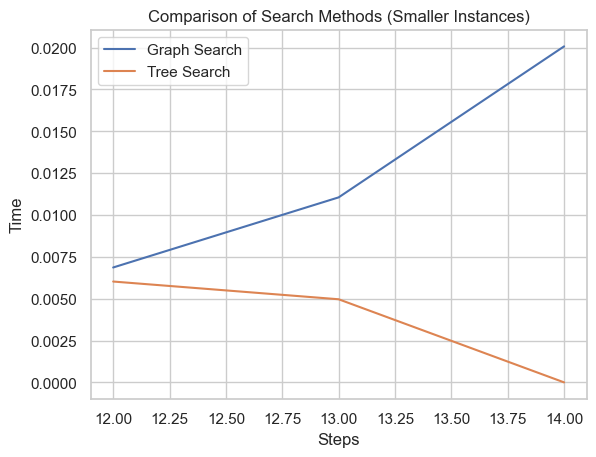

In [15]:
sns.set(style="whitegrid")

sns.lineplot(x='steps', y='asgs', data=data.iloc[:3], label='Graph Search')
sns.lineplot(x='steps', y='asts', data=data.iloc[:3], label='Tree Search')

plt.xlabel('Steps')
plt.ylabel('Time')
plt.title('Comparison of Search Methods (Smaller Instances)')
plt.legend()

plt.show()

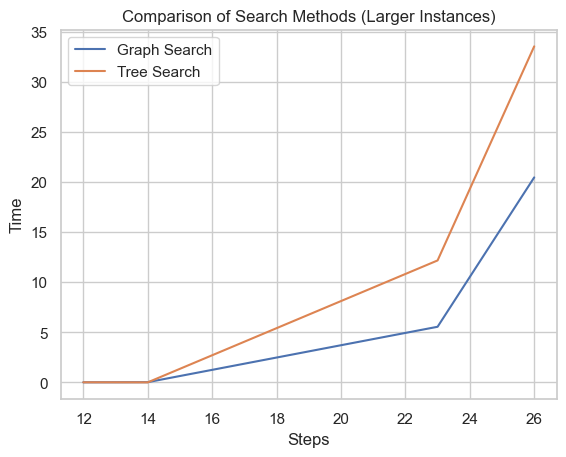

In [16]:
sns.set(style="whitegrid")

sns.lineplot(x='steps', y='asgs', data=data, label='Graph Search')
sns.lineplot(x='steps', y='asts', data=data, label='Tree Search')

plt.xlabel('Steps')
plt.ylabel('Time')
plt.title('Comparison of Search Methods (Larger Instances)')
plt.legend()

plt.show()